In [9]:
# Importar librerías básicas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [10]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Importar librerías básicas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- 1. Carga datasets sin etiquetas (sin labels para SSL) ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=64,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=64,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

# Normalizar pixeles a [0, 1]
def normalize_img(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img

train_dataset = train_dataset.map(lambda x: normalize_img(x))
val_dataset = val_dataset.map(lambda x: normalize_img(x))
train_dataset = train_dataset.map(lambda x: (x, x)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x: (x, x)).shuffle(1000).prefetch(tf.data.AUTOTUNE)

# --- 2. Definir patch embedding para ViT ---
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# --- 3. Dividir imagen en parches ---
def extract_patches(images, patch_size=16):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

# --- 4. Modelo MAE simple ---
def create_mae(input_shape=(128,128,3), patch_size=16, projection_dim=64, encoder_layers=4, decoder_layers=2):

    inputs = layers.Input(shape=input_shape)
    patches = layers.Lambda(lambda x: extract_patches(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Patch embedding
    projection = layers.Dense(projection_dim)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def patch_encoding(patches):
        positions = tf.range(start=0, limit=num_patches, delta=1)
        encoded = projection(patches) + position_embedding(positions)
        return encoded
    

    # Encoder (transformer)
    for _ in range(encoder_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = layers.Dense(projection_dim * 4, activation="gelu")(x3)
        x5 = layers.Dense(projection_dim)(x4)  # <--- CORRECCIÓN aquí
        encoded_patches = layers.Add()([x2, x5])

    # Decoder input (puede ser same que encoder o más dimensiones)
    x = encoded_patches

    # Decoder (transformer)
    for _ in range(decoder_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, x])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = layers.Dense(projection_dim * 4, activation="gelu")(x3)
        x5 = layers.Dense(projection_dim)(x4)  # <--- CORRECCIÓN aquí
        x = layers.Add()([x2, x5])

    # Reconstrucción patches al espacio original de pixeles (dim_patch)
    patch_dim = patch_size * patch_size * input_shape[2]
    decoded_patches = layers.Dense(patch_dim)(x)  # Proyectar de vuelta a pixel patches

    # Reconstrucción imagen completa
    def reconstruct_image(patches):
        batch_size = tf.shape(patches)[0]
        patches = tf.reshape(patches, [batch_size,
                                       input_shape[0] // patch_size,
                                       input_shape[1] // patch_size,
                                       patch_size, patch_size,
                                       input_shape[2]])
        patches = tf.transpose(patches, perm=[0,1,3,2,4,5])
        image = tf.reshape(patches, [batch_size, input_shape[0], input_shape[1], input_shape[2]])
        return image

    outputs = layers.Lambda(reconstruct_image)(decoded_patches)

    # Modelo completo
    mae = keras.Model(inputs=inputs, outputs=outputs)
    return mae

# --- 5. Crear el modelo ---
mae_model = create_mae()

def psnr_metric(y_true, y_pred):
    # Valores en [0,1]
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    # Valores en [0,1]
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

mae_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[psnr_metric, ssim_metric]
)

history = mae_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)
save_path = "best_mae.h5"
mae_model.save(save_path)

# --- 7. (Opcional) Extraer encoder para downstream classification ---

# Aquí tomarías solo la parte encoder para entrenar con etiquetas supervisadas


Found 21000 files belonging to 1 classes.
Found 3000 files belonging to 1 classes.


ValueError: Exception encountered when calling layer "lambda_3" (type Lambda).


The following Variables were created within a Lambda layer (lambda_3)
but are not tracked by said layer:
  <tf.Variable 'lambda_3/dense_14/kernel:0' shape=(768, 64) dtype=float32>
  <tf.Variable 'lambda_3/dense_14/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'lambda_3/embedding_1/embeddings:0' shape=(64, 64) dtype=float32>
The layer cannot safely ensure proper Variable reuse across multiple
calls, and consequently this behavior is disallowed for safety. Lambda
layers are not well suited to stateful computation; instead, writing a
subclassed Layer is the recommend way to define layers with
Variables.

Call arguments received by layer "lambda_3" (type Lambda):
  • inputs=tf.Tensor(shape=(None, None, 768), dtype=float32)
  • mask=None
  • training=False

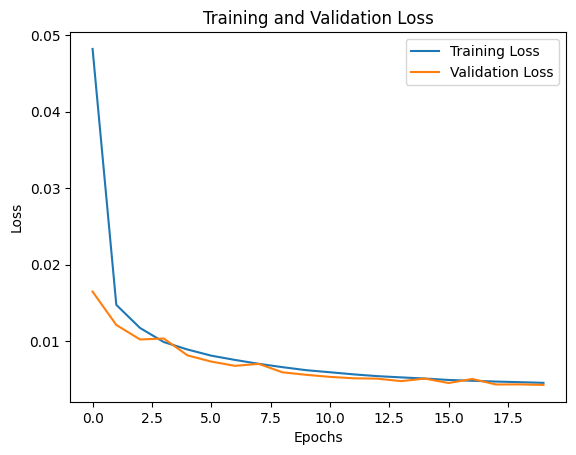

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)